In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications import Xception


In [9]:
base_dir = "./data/ui_icons_dataset/"
train_dir = (os.path.join(base_dir,"train/"))
validation_dir = os.path.join(base_dir, "validation/")

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255, preprocessing_function=tf.image.rgb_to_grayscale)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224),
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        class_mode='categorical')

Found 11249 images belonging to 21 classes.
Found 1241 images belonging to 21 classes.


In [21]:
EPOCHS = 15
STEPS = 120

In [32]:
def create_model():
    batch_size = 32
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:-5]:
        layer.trainable = True
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    predictions = tf.keras.layers.Dense(21, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [33]:
model = create_model()
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5,min_delta=0.005, mode='max', verbose=1),
 ModelCheckpoint('Xception.h5', monitor='val_loss', mode='max', save_best_only=True, save_weights_only=True),
 EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
history = model.fit( train_generator, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,validation_data = validation_generator,callbacks = callbacks)


Epoch 1/15
120/120 [==============================] - 192s 2s/step - loss: 1.8158 - accuracy: 0.4422 - val_loss: 1.4318 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 2/15
120/120 [==============================] - 183s 2s/step - loss: 1.4282 - accuracy: 0.5474 - val_loss: 1.3085 - val_accuracy: 0.5657 - lr: 0.0010
Epoch 3/15
120/120 [==============================] - 181s 2s/step - loss: 1.3117 - accuracy: 0.5736 - val_loss: 1.3197 - val_accuracy: 0.5689 - lr: 0.0010
Epoch 4/15
120/120 [==============================] - 182s 2s/step - loss: 1.2641 - accuracy: 0.5909 - val_loss: 1.2244 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 5/15
120/120 [==============================] - 181s 2s/step - loss: 1.1926 - accuracy: 0.6076 - val_loss: 1.2110 - val_accuracy: 0.6108 - lr: 0.0010
Epoch 6/15
120/120 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.6023
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
120/120 [==============================] - 182s

Text(0.5, 1.0, 'Training and validation loss')

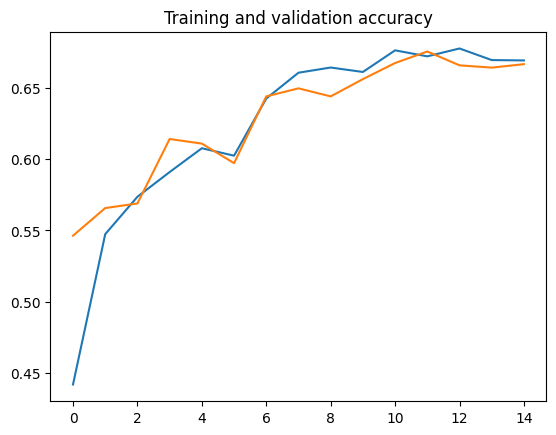

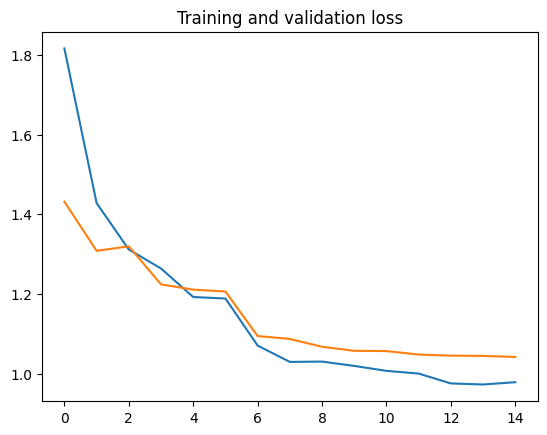

In [34]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [35]:
model_save_path = 'xception'

# Save the model
model.save(model_save_path)

INFO:tensorflow:Assets written to: xception\assets


INFO:tensorflow:Assets written to: xception\assets


In [36]:
model_test  = tf.keras.models.load_model('xception')

base_dir = "./data/ui_icons_dataset/"
test_dir = os.path.join(base_dir, "test/test")

IDs2 = []
Target2 = []

for i in range(len(os.listdir(test_dir))):
    image = cv2.imread(os.path.join(test_dir,os.listdir(test_dir)[i]))
    image = cv2.resize(image,(224,224)) 
    image = image.reshape(1,224,224,3)

    IDs2.append(os.listdir(test_dir)[i])

    prediction = model_test.predict(image)
    max_index = np.argmax(prediction)

    Target2.append(os.listdir(train_dir)[max_index])
            
df2 = pd.DataFrame({'ID': IDs2, 'Target': Target2})

1/1 [==============================] - 0s 142ms/step


In [37]:
df2.to_csv('predictions_xception.csv', index=False)

In [38]:
df = pd.read_csv("predictions_xception.csv")

In [39]:
class_counts = df['Target'].value_counts()

# Display the class counts
print(class_counts)

Target
slider                    4944
label                      100
button                      68
switch_disabled              9
data_table                   8
image                        7
radio_button_unchecked       5
chip                         2
Name: count, dtype: int64


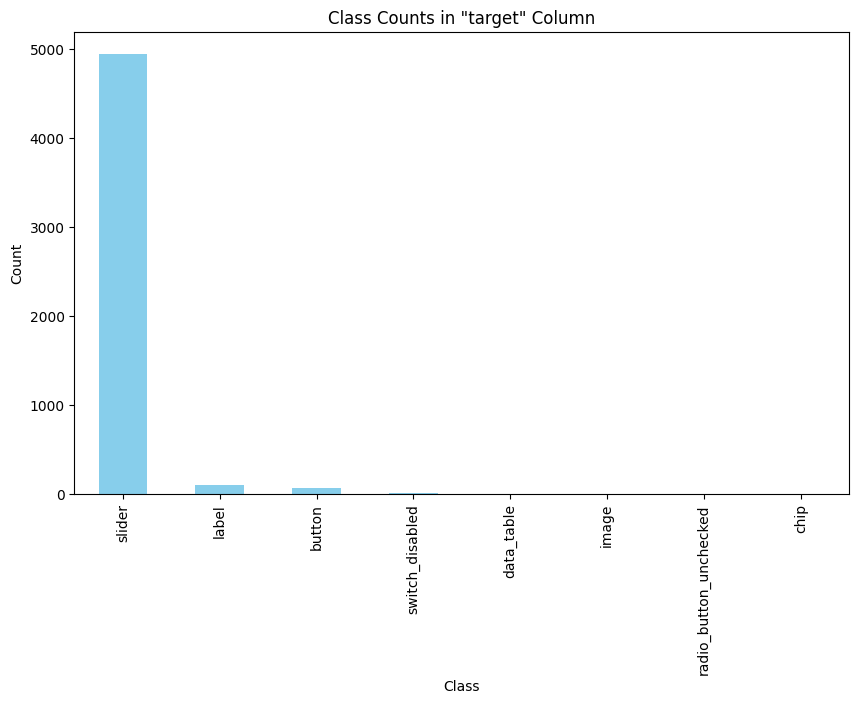

In [40]:
class_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Class Counts in "target" Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()